In [36]:
# https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
# https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf

In [37]:
import sys
sys.executable

'/home/codespace/anaconda3/envs/MLOps/bin/python'

In [38]:
import pandas as pd
import sklearn 

# graphics
import seaborn as sns
import matplotlib.pyplot as plt

# feature
from sklearn.feature_extraction import DictVectorizer

In [39]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-04.parquet')
# df = df[df.trip_type == 2]
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-04-01 00:18:50,2024-04-01 00:19:48,N,1.0,146,146,1.0,0.15,3.7,1.0,0.5,0.00,0.0,NaN,1.0,6.20,2.0,1.0,0.00
1,2,2024-04-01 00:56:16,2024-04-01 01:12:56,N,1.0,65,225,1.0,3.06,17.7,1.0,0.5,4.04,0.0,NaN,1.0,24.24,1.0,1.0,0.00
2,2,2024-04-01 00:23:09,2024-04-01 00:33:03,N,1.0,226,146,1.0,1.95,11.4,1.0,0.5,3.48,0.0,NaN,1.0,17.38,1.0,1.0,0.00
3,2,2024-03-31 22:34:23,2024-03-31 22:45:33,N,1.0,74,116,1.0,1.93,12.8,1.0,0.5,3.06,0.0,NaN,1.0,18.36,1.0,1.0,0.00
4,2,2024-03-31 23:21:41,2024-03-31 23:29:40,N,1.0,236,238,1.0,1.50,10.7,1.0,0.5,0.80,0.0,NaN,1.0,16.75,1.0,1.0,2.75


In [40]:
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

In [41]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [42]:
df.duration = df.duration.apply(lambda x: x.total_seconds() / 60) # time in minutes
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-04-01 00:18:50,2024-04-01 00:19:48,N,1.0,146,146,1.0,0.15,3.7,...,0.5,0.00,0.0,NaN,1.0,6.20,2.0,1.0,0.00,0.966667
1,2,2024-04-01 00:56:16,2024-04-01 01:12:56,N,1.0,65,225,1.0,3.06,17.7,...,0.5,4.04,0.0,NaN,1.0,24.24,1.0,1.0,0.00,16.666667
2,2,2024-04-01 00:23:09,2024-04-01 00:33:03,N,1.0,226,146,1.0,1.95,11.4,...,0.5,3.48,0.0,NaN,1.0,17.38,1.0,1.0,0.00,9.900000
3,2,2024-03-31 22:34:23,2024-03-31 22:45:33,N,1.0,74,116,1.0,1.93,12.8,...,0.5,3.06,0.0,NaN,1.0,18.36,1.0,1.0,0.00,11.166667
4,2,2024-03-31 23:21:41,2024-03-31 23:29:40,N,1.0,236,238,1.0,1.50,10.7,...,0.5,0.80,0.0,NaN,1.0,16.75,1.0,1.0,2.75,7.983333


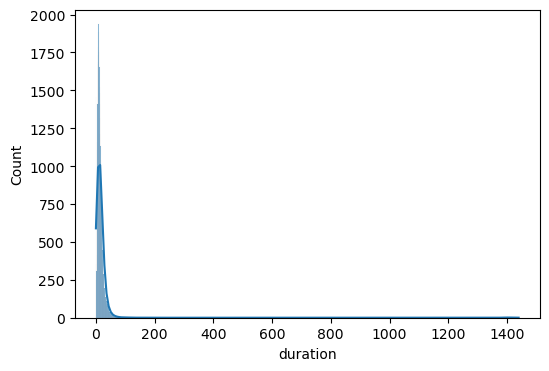

In [43]:
plt.figure(figsize=(6, 4))

sns.histplot(df.duration, kde=True)

plt.show()

In [44]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    56471.000000
mean        18.408817
std         74.060173
min          0.000000
50%         11.650000
95%         35.000000
98%         48.136667
99%         64.633333
max       1439.866667
Name: duration, dtype: float64

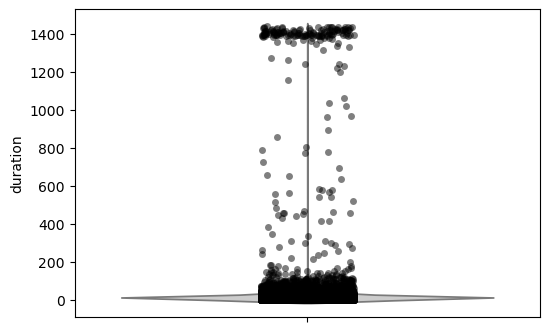

In [45]:
plt.figure(figsize=(6, 4))

# Create the violin plot
sns.violinplot(y='duration', data=df, inner=None, color=".8")
sns.stripplot(y='duration', data=df, jitter=True, color='k', alpha=0.5)

# Show the plot
plt.show()

In [46]:
((df.duration >= 0) & (df.duration <= 100)).mean()

0.9946875387366967

In [47]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'duration'],
      dtype='object')

In [48]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [49]:
df[categorical] = df[categorical].astype(str)
df.dtypes

VendorID                          int32
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [50]:
train_dics = df[categorical + numerical].to_dict(orient='records')
train_dics

[{'PULocationID': '146', 'DOLocationID': '146', 'trip_distance': 0.15},
 {'PULocationID': '65', 'DOLocationID': '225', 'trip_distance': 3.06},
 {'PULocationID': '226', 'DOLocationID': '146', 'trip_distance': 1.95},
 {'PULocationID': '74', 'DOLocationID': '116', 'trip_distance': 1.93},
 {'PULocationID': '236', 'DOLocationID': '238', 'trip_distance': 1.5},
 {'PULocationID': '92', 'DOLocationID': '92', 'trip_distance': 2.02},
 {'PULocationID': '129', 'DOLocationID': '129', 'trip_distance': 0.54},
 {'PULocationID': '83', 'DOLocationID': '82', 'trip_distance': 1.42},
 {'PULocationID': '83', 'DOLocationID': '196', 'trip_distance': 2.3},
 {'PULocationID': '260', 'DOLocationID': '80', 'trip_distance': 4.47},
 {'PULocationID': '82', 'DOLocationID': '160', 'trip_distance': 3.71},
 {'PULocationID': '132', 'DOLocationID': '132', 'trip_distance': 0.11},
 {'PULocationID': '7', 'DOLocationID': '7', 'trip_distance': 0.0},
 {'PULocationID': '129', 'DOLocationID': '83', 'trip_distance': 0.98},
 {'PULoca

In [51]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dics)
target = df.duration

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.15],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 3.06],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.95],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.5 ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 3.37],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.94]])